# Detecting Controversy in ChatGPT Dialogues


# Student Numbers
- Tim Rößling (175881)
- Sebastian Uedingslohmann (175867)
- Johan Schommartz (175871)
- Max Bernard (175870)

# Data Collection

## Import Libraries

pip install needed libraries

In [1]:
!pip install \
  pandas \
  scikit-learn \
  datasets \
  seaborn \
  nltk \
  pyLDAvis \
  textblob \
  vaderSentiment \
  tensorflow \
  transformers \
  xgboost \
  lightgbm \
  tf-keras \
  torch


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 50.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 33.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 109.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 145.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.0/865.0 MB 95.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━

In [2]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import re
import string
import time
from collections import Counter
from joblib import Parallel, delayed

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer

# Sentiment analysis libraries
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Topic modeling libraries
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import TfidfModel, LdaModel, LdaMulticore
from gensim.corpora import Dictionary
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Scikit-learn libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import LabelPropagation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.cluster import KMeans

# Deep learning libraries
import torch
from transformers import AutoTokenizer, AutoModel, TFAutoModel
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    GlobalAveragePooling1D,
    LSTM,
    Embedding,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Dataset library
from datasets import load_dataset

# Download NLTK data
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("vader_lexicon")
nltk.download("punkt_tab")
# Set up device and seeds
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)
# Settings
warnings.filterwarnings("ignore")

2025-05-29 21:47:33.255520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748548053.276336     456 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748548053.282566     456 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748548053.298684     456 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748548053.298703     456 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748548053.298705     456 computation_placer.cc:177] computation placer alr

Using device: cpu


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Dataset Loading

We source the wildchat1m dataset from the Hugging Face Hub, due to access restrictions we were only able to source the training set.

In [3]:
wildchat1m = load_dataset("allenai/WildChat-1M")
df = wildchat1m["train"].to_pandas()
df.head()

README.md:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

data/train-00000-of-00014.parquet:   0%|          | 0.00/231M [00:00<?, ?B/s]

data/train-00001-of-00014.parquet:   0%|          | 0.00/215M [00:00<?, ?B/s]

data/train-00002-of-00014.parquet:   0%|          | 0.00/206M [00:00<?, ?B/s]

data/train-00003-of-00014.parquet:   0%|          | 0.00/217M [00:00<?, ?B/s]

data/train-00004-of-00014.parquet:   0%|          | 0.00/208M [00:00<?, ?B/s]

data/train-00005-of-00014.parquet:   0%|          | 0.00/201M [00:00<?, ?B/s]

data/train-00006-of-00014.parquet:   0%|          | 0.00/190M [00:00<?, ?B/s]

data/train-00007-of-00014.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

data/train-00008-of-00014.parquet:   0%|          | 0.00/181M [00:00<?, ?B/s]

data/train-00009-of-00014.parquet:   0%|          | 0.00/269M [00:00<?, ?B/s]

data/train-00010-of-00014.parquet:   0%|          | 0.00/336M [00:00<?, ?B/s]

data/train-00011-of-00014.parquet:   0%|          | 0.00/300M [00:00<?, ?B/s]

data/train-00012-of-00014.parquet:   0%|          | 0.00/283M [00:00<?, ?B/s]

data/train-00013-of-00014.parquet:   0%|          | 0.00/336M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/837989 [00:00<?, ? examples/s]

,conversation_hash,model,timestamp,conversation,turn,language,openai_moderation,detoxify_moderation,toxic,redacted,state,country,hashed_ip,header
0,c9ec5b440fbdd2a269333dd241f32f64,gpt-4-0314,2023-04-09 00:02:53+00:00,[{'content': 'Hey there! Are you familiar with...,1,English,"[{'categories': {'harassment': False, 'harassm...","[{'identity_attack': 0.00020589135237969458, '...",False,False,Texas,United States,22fd87ba9b98f3d379b23c7b52961f2d4a8505127e58b3...,"{'accept-language': 'en-US,en;q=0.9,es;q=0.8',..."
1,34f1581760df304d539e2fe4653b40d3,gpt-4-0314,2023-04-09 00:03:20+00:00,[{'content': 'Crea una imagen de una mujer cor...,2,Spanish,"[{'categories': {'harassment': False, 'harassm...","[{'identity_attack': 0.007170863449573517, 'in...",False,False,A Coruña,Spain,58369722cd0bdf7fc027a67491ba65b74576df6994c36c...,"{'accept-language': 'es-ES,es;q=0.9,en;q=0.8',..."
2,cf1267ca6b2f6fccc9c36652a00059a1,gpt-4-0314,2023-04-09 00:04:52+00:00,"[{'content': 'Old age PT hx of DM, HTN, dyslip...",1,English,"[{'categories': {'harassment': False, 'harassm...","[{'identity_attack': 0.0002258022577734664, 'i...",False,False,Mecca Region,Saudi Arabia,8133108d1c433c180c6be8302dc5a6681f2bec980190a1...,"{'accept-language': 'en-US,en;q=0.9', 'user-ag..."
3,7f1c97a4f873cda8106b010d040be078,gpt-4-0314,2023-04-09 00:06:29+00:00,[{'content': 'calcula la mediana de followers:...,1,Catalan,"[{'categories': {'harassment': False, 'harassm...","[{'identity_attack': 0.0003390185011085123, 'i...",False,False,Barcelona,Spain,846e43fb5fbb4b8cfbafa17083387aad62e58f5fb23482...,"{'accept-language': 'es,es-ES;q=0.9,en;q=0.8,e..."
4,e98d3e74c57f9a65261df393d9124ac2,gpt-4-0314,2023-04-09 00:06:49+00:00,[{'content': 'Hey there! Are you familiar with...,1,English,"[{'categories': {'harassment': False, 'harassm...","[{'identity_attack': 0.00020642601884901524, '...",False,False,Texas,United States,22fd87ba9b98f3d379b23c7b52961f2d4a8505127e58b3...,"{'accept-language': 'en-US,en;q=0.9,es;q=0.8',..."


## Data Description

Get basic information about the dataset.

In [4]:
print(df.shape)

(837989, 14)


In [5]:
print(df.columns)

Index(['conversation_hash', 'model', 'timestamp', 'conversation', 'turn',
       'language', 'openai_moderation', 'detoxify_moderation', 'toxic',
       'redacted', 'state', 'country', 'hashed_ip', 'header'],
      dtype='object')


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837989 entries, 0 to 837988
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   conversation_hash    837989 non-null  object             
 1   model                837989 non-null  object             
 2   timestamp            837989 non-null  datetime64[us, UTC]
 3   conversation         837989 non-null  object             
 4   turn                 837989 non-null  int64              
 5   language             837989 non-null  object             
 6   openai_moderation    837989 non-null  object             
 7   detoxify_moderation  837989 non-null  object             
 8   toxic                837989 non-null  bool               
 9   redacted             837989 non-null  bool               
 10  state                674810 non-null  object             
 11  country              836929 non-null  object             
 12  ha

In [7]:
print(df["conversation"][507])

[{'content': "A Christian who doesn't believe in evolution named Gina has a mother. Her mother had a mother, and so forth. If we go back one million generations of mothers, what species would Gina's mother one million generations ago be? Rate using a scale of 1 to 10 your confidence that your answer is correct. ", 'country': 'United States', 'hashed_ip': '9d9f230c2533fb238693546aea1149f356eb9442a497cebfdf515859fe782045', 'header': {'accept-language': 'en-US,en;q=0.5', 'user-agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:78.0) Gecko/20100101 Firefox/78.0'}, 'language': 'English', 'redacted': False, 'role': 'user', 'state': 'Wisconsin', 'timestamp': None, 'toxic': False, 'turn_identifier': 103226}
 {'content': "Gina's ancestor one million generations ago would likely have been a species of primate, but not a modern human. It is difficult to pinpoint the exact species due to the complexities of human evolution and the fact that one million generations is a rough estimation. On a scale of 1 t

In [8]:
print(f"Number of duplicate hashed ips: {(df['hashed_ip'].value_counts() > 1).sum()}")
print(
    f"Number of duplicate hashed conversations: {(df['conversation_hash'].value_counts() > 1).sum()}"
)

df = df.drop_duplicates(subset="conversation_hash", keep="first").reset_index(drop=True)

Number of duplicate hashed ips: 78670
Number of duplicate hashed conversations: 1549


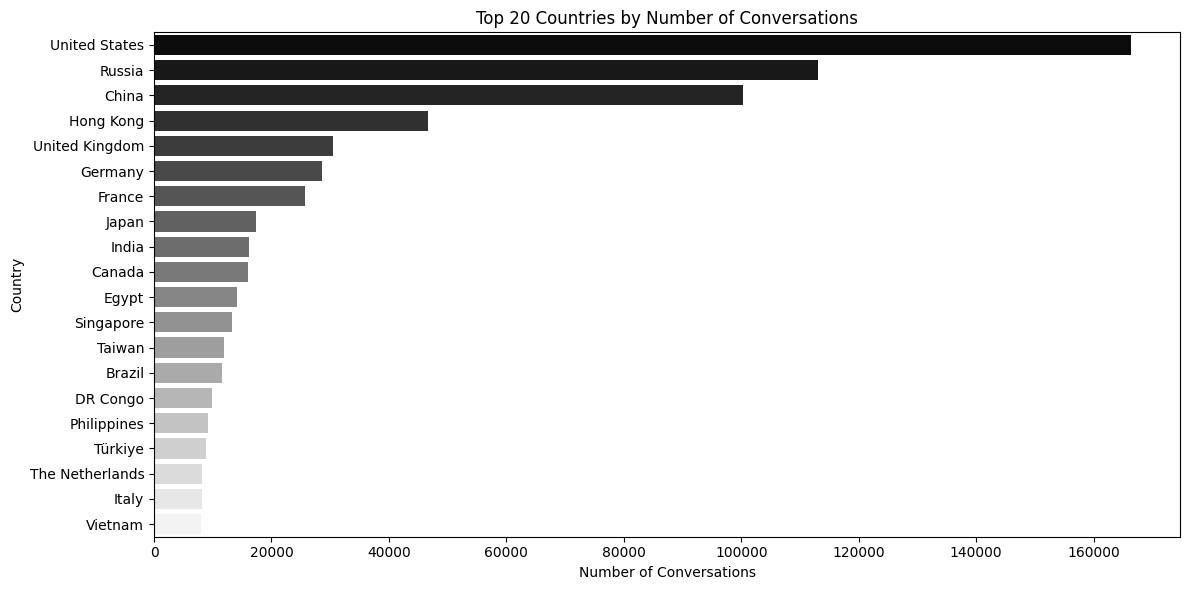

In [9]:
top_countries = df["country"].value_counts().head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="gray")
plt.title("Top 20 Countries by Number of Conversations")
plt.xlabel("Number of Conversations")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

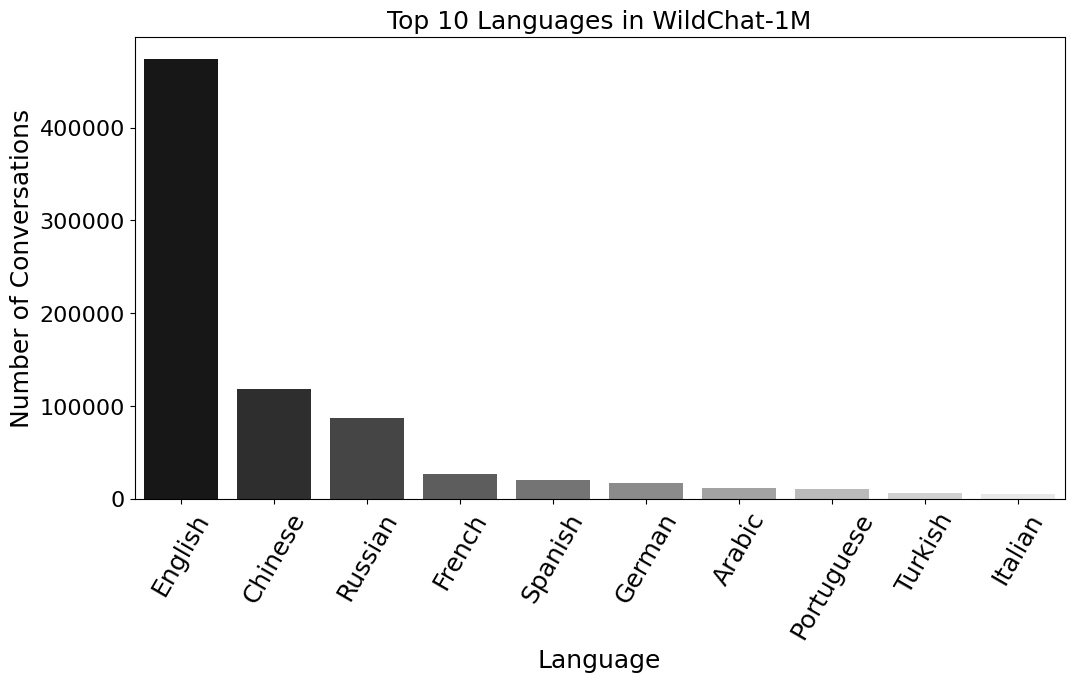

In [16]:
top_languages = df["language"].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_languages.index, y=top_languages.values, palette="gray")
plt.xticks(rotation=60, fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel("Language", fontsize=18)
plt.ylabel("Number of Conversations", fontsize=18)
plt.title("Top 10 Languages in WildChat-1M", fontsize=18)
plt.show()

In [11]:
country_counts = df["country"].value_counts().head(5)
total_conversations = len(df)

df_country_dist = country_counts.to_frame(name="count")
df_country_dist["Share"] = (df_country_dist["count"] / total_conversations * 100).round(
    2
)

english_counts = df[df["language"] == "English"]["country"].value_counts()
df_country_dist["English Share"] = (
    english_counts.reindex(df_country_dist.index).fillna(0)
    / df_country_dist["count"]
    * 100
).round(2)

df_country_dist = df_country_dist.reset_index().rename(columns={"index": "Country"})

print(df_country_dist)


          country   count  Share  English Share
0   United States  166382  20.14          86.96
1          Russia  113092  13.69          31.09
2           China  100373  12.15          33.98
3       Hong Kong   46654   5.65          57.17
4  United Kingdom   30501   3.69          92.06


# Data Preprocessing

## Data Filtering

In [12]:
df = df[(df["language"] == "English") & (df["turn"] >= 2)].reset_index(drop=True)
print(f" Length of dataframe after filtering for language and turns: {len(df)}")

 Length of dataframe after filtering for language and turns: 159126


We organize into quarters and get a sample of 10000 for each quarter.

In [13]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["quarter"] = df["timestamp"].dt.to_period("Q")


quarters = df["quarter"].unique()
quarters = sorted(quarters)
print(f"Available quarters: {quarters}")


sample_per_quarter = 50000 // len(quarters)
remaining_samples = 50000 % len(quarters)

sampled_dfs = []
for i, quarter in enumerate(quarters):
    quarter_df = df[df["quarter"] == quarter]

    n_samples = sample_per_quarter + (1 if i < remaining_samples else 0)
    n_samples = min(n_samples, len(quarter_df))

    quarter_sample = quarter_df.sample(n=n_samples, random_state=42)
    sampled_dfs.append(quarter_sample)
    print(
        f"Quarter {quarter}: sampled {n_samples} from {len(quarter_df)} conversations"
    )


df_sample = pd.concat(sampled_dfs, ignore_index=True)
print(f"Total sampled conversations: {len(df_sample)}")

Available quarters: [Period('2023Q2', 'Q-DEC'), Period('2023Q3', 'Q-DEC'), Period('2023Q4', 'Q-DEC'), Period('2024Q1', 'Q-DEC'), Period('2024Q2', 'Q-DEC')]
Quarter 2023Q2: sampled 10000 from 53036 conversations
Quarter 2023Q3: sampled 10000 from 34678 conversations
Quarter 2023Q4: sampled 10000 from 34757 conversations
Quarter 2024Q1: sampled 10000 from 24628 conversations
Quarter 2024Q2: sampled 10000 from 12027 conversations
Total sampled conversations: 50000


## Text Processing

In [14]:
df_sample["conversation_text"] = df_sample["conversation"].apply(
    lambda conv: " ".join([turn["content"] for turn in conv])
)
df_sample["conversation_text"].head(5)

0    (David’s colleague Clare sometimes hypnotizes ...
1    popular stocks with less than 10$ per share He...
2    hi, could you make a javascript code for my di...
3    Is there a way to run lua inside of a batch fi...
4    imagine the POWER you could have if you had ac...
Name: conversation_text, dtype: object

We extract the messages from each conversation in the dataset. User messages are separated from assistant messages text strings are created that can be used for further analysis and processing.

In [ ]:
df_sample["user_messages"] = df_sample["conversation"].apply(
    lambda conv: [turn["content"] for turn in conv if turn["role"] == "user"]
)

df_sample["user_text"] = df_sample["user_messages"].apply(lambda x: " ".join(x))

We perform essential preprocessing steps to prepare the text data for analysis, like tokenization, stopword removal, and lemmatization.

In [16]:
lem = WordNetLemmatizer()
stop_words = stopwords.words("english")


def data_preprocess(text):
    wtokens = word_tokenize(text)

    t_filtered = []
    for t in wtokens:
        if t.lower() not in stop_words and t.isalpha():
            t_filtered.append(t.lower())

    t_lemmatized = []
    for t in t_filtered:
        lemma_t = lem.lemmatize(t)
        t_lemmatized.append(lemma_t)

    return " ".join(t_lemmatized)

We use parallel processing to speed up the text processingand invalid processed messages are removed.

In [17]:
def process_user_text(msgs):
    return data_preprocess(" ".join(msgs))


def tokenize_text(text):
    return word_tokenize(text)


df_sample["user_text_processed"] = Parallel(n_jobs=-1)(
    delayed(process_user_text)(msgs) for msgs in df_sample["user_messages"]
)


df_sample = df_sample.dropna(subset=["user_text_processed"]).reset_index(drop=True)
df_sample = df_sample[df_sample["user_text_processed"].str.strip() != ""].reset_index(
    drop=True
)
print(f"Removed empty/invalid preprocessed texts. Remaining rows: {len(df_sample)}")


df_sample["user_tokens"] = Parallel(n_jobs=-1)(
    delayed(tokenize_text)(text) for text in df_sample["user_text_processed"]
)

Removed empty/invalid preprocessed texts. Remaining rows: 49964


## Feature Extraction

the moderation scores are provided by openai

In [18]:
def extract_moderation_scores(moderation_array):
    if moderation_array is None or len(moderation_array) == 0:
        return 0.0

    moderation = moderation_array[0]

    if "category_scores" not in moderation:
        return 0.0

    scores = moderation["category_scores"]

    if scores is None:
        return 0.0

    harassment = scores["harassment"]
    hate = scores["hate"]
    sexual = scores["sexual"]
    violence = scores["violence"]

    moderation_score = harassment + hate + sexual + violence

    return moderation_score

In [19]:
df_sample["moderation_score"] = df_sample["openai_moderation"].apply(
    extract_moderation_scores
)

In [20]:
scaler = MinMaxScaler()
df_sample["moderation_score"] = scaler.fit_transform(df_sample[["moderation_score"]])

## Feature Engineering

### Discourse Markers

we refer to the ARGUE corpus for discourse markers, following Abbott et al. 2021

In [21]:
discourse_markers = [
    "actually",
    "and",
    "because",
    "but",
    "i believe",
    "i know",
    "i see",
    "i think",
    "just",
    "no",
    "oh",
    "really",
    "so",
    "well",
    "yes",
    "you know",
    "you mean",
]


def count_discourse_markers(text_list):
    text = " ".join(text_list).lower()
    counts = {}
    for marker in discourse_markers:
        # Create a pattern that handles word boundaries correctly for multi-word markers
        pattern = r"\b" + re.escape(marker) + r"\b"
        counts[marker] = len(re.findall(pattern, text))
    return counts

We compute the proportion of discourse markers in each message otherwise longer messages would be overrepresented in the analysis.

In [22]:
df_sample["discourse_marker_counts"] = df_sample["user_messages"].apply(
    count_discourse_markers
)
df_sample["total_discourse_markers"] = df_sample["discourse_marker_counts"].apply(
    lambda x: sum(x.values())
)
df_sample["total_tokens"] = df_sample["user_messages"].apply(
    lambda x: sum(len(m.split()) for m in x)
)
df_sample["discourse_marker_density"] = (
    df_sample["total_discourse_markers"] / df_sample["total_tokens"]
)

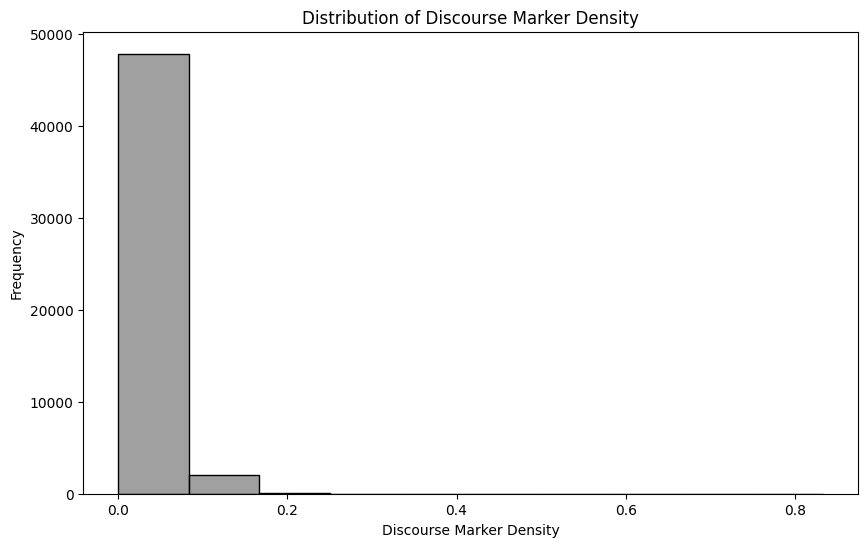

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(df_sample["discourse_marker_density"], bins=10, kde=False, color="gray")
plt.title("Distribution of Discourse Marker Density")
plt.xlabel("Discourse Marker Density")
plt.ylabel("Frequency")
plt.show()

In [24]:
df_sample["discourse_marker_density"] = scaler.fit_transform(
    df_sample[["discourse_marker_density"]]
)

### Sentiment Features

#### Valence Aware Dictionary and Sentiment Reasoner (VADER)

In [25]:
# VADER scoring function
sia = SentimentIntensityAnalyzer()


def vader_scores(msg_list):
    if not isinstance(msg_list, list) or not msg_list:
        return []
    return [sia.polarity_scores(m)["compound"] for m in msg_list]


df_sample["user_sentiment"] = Parallel(n_jobs=-1)(
    delayed(vader_scores)(msgs) for msgs in df_sample["user_messages"]
)


**Sentiment Standard Deviation, Range, and Shift**

 These features reflect emotional volatility, which is known to correlate with disagreement and polarization in dialogue.

In [26]:
df_sample["user_sentiment_std"] = df_sample["user_sentiment"].apply(lambda x: np.std(x))
df_sample["user_sentiment_range"] = df_sample["user_sentiment"].apply(
    lambda x: np.max(x) - np.min(x)
)
df_sample["user_sentiment_shift"] = df_sample["user_sentiment"].apply(
    lambda x: x[-1] - x[0]
)

In [27]:
df_sample[["user_sentiment_range", "user_sentiment_shift"]] = scaler.fit_transform(
    df_sample[["user_sentiment_range", "user_sentiment_shift"]]
)

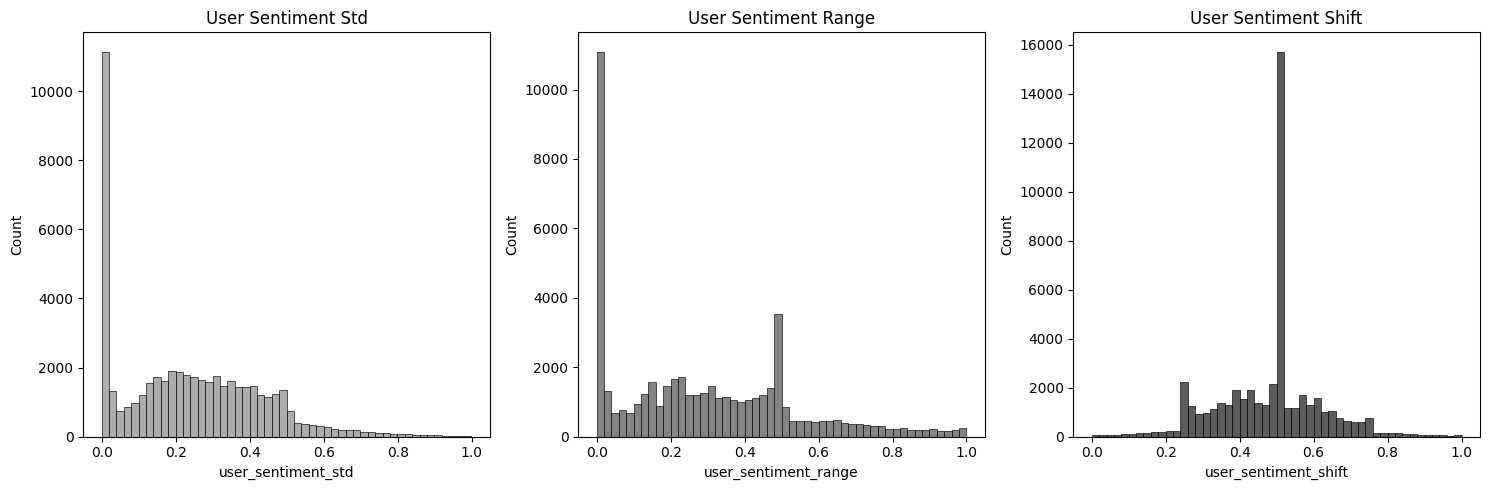

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(
    data=df_sample,
    x="user_sentiment_std",
    bins=50,
    color="#999999",
    alpha=0.8,
    ax=axes[0],
)
axes[0].set_title("User Sentiment Std")

sns.histplot(
    data=df_sample,
    x="user_sentiment_range",
    bins=50,
    color="#666666",
    alpha=0.8,
    ax=axes[1],
)
axes[1].set_title("User Sentiment Range")

sns.histplot(
    data=df_sample,
    x="user_sentiment_shift",
    bins=50,
    color="#333333",
    alpha=0.8,
    ax=axes[2],
)
axes[2].set_title("User Sentiment Shift")

plt.tight_layout()
plt.show()

#### Subjectivity Score

 Subjectivity serves as a proxy for emotional or biased expression (Mejova et al., 2014)

In [29]:
def get_subjectivity(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0.0
    return TextBlob(text).sentiment.subjectivity

In [30]:
df_sample["user_subjectivity"] = df_sample["user_text_processed"].apply(
    get_subjectivity
)

# Data Labeling

An initial heuristic score helps to start the labeling.

In [31]:
df_sample["controversy_score"] = (
    0.2 * df_sample["user_subjectivity"]
    + 0.2 * df_sample["user_sentiment_std"]
    + 0.2 * df_sample["discourse_marker_density"]
    + 0.1 * df_sample["moderation_score"]
    + 0.2 * df_sample["user_sentiment_range"]
    + 0.1 * df_sample["user_sentiment_shift"]
)

## Label Propagation

Scikit-learn's LabelPropagation is used to propagate labels from a small set of labeled data to the larger unlabeled dataset. We use 4000 for the top_controversial and 4000 for the bottom_controversial as starting point for the label propagation.

In [32]:
top_controversial = df_sample.nlargest(4000, "controversy_score").index
bottom_controversial = df_sample.nsmallest(4000, "controversy_score").index


df_sample["controversial"] = -1
df_sample.loc[top_controversial, "controversial"] = 1
df_sample.loc[bottom_controversial, "controversial"] = 0


X = df_sample[
    [
        "user_sentiment_std",
        "user_sentiment_shift",
        "user_sentiment_range",
        "moderation_score",
        "discourse_marker_density",
        "user_subjectivity",
    ]
].values

y = df_sample["controversial"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


lp = LabelPropagation(kernel="rbf", gamma=5, max_iter=1000, n_jobs=-1)
lp.fit(X_scaled, y)

df_sample["controversial"] = lp.transduction_


In [33]:
print(df_sample["controversial"].value_counts().sort_index())

controversial
0    43094
1     6870
Name: count, dtype: int64


To visualize the label propagation we use PCA to reduce the dimensionality of the data and plot it in a 2D space.

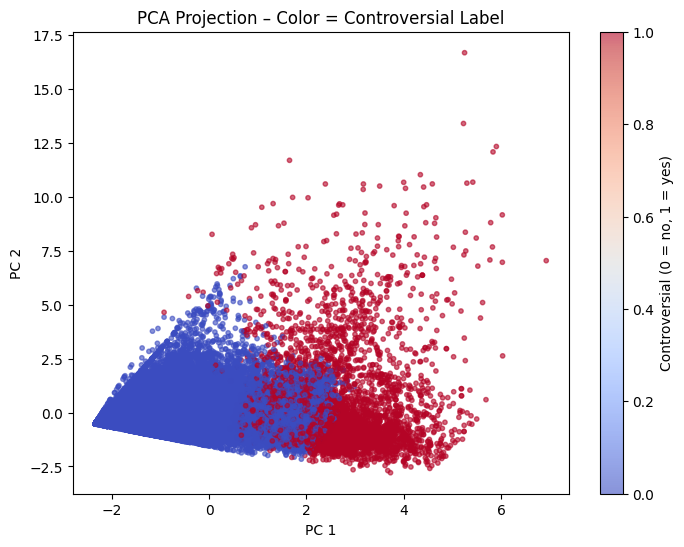

In [34]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=df_sample["controversial"],
    cmap="coolwarm",
    alpha=0.6,
    s=10,
)
plt.title("PCA Projection – Color = Controversial Label")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label="Controversial (0 = no, 1 = yes)")
plt.show()

## EDA on Labeled Data

With the newly created labels, we can identfiy the amount  of controvresial messages in each quarter.

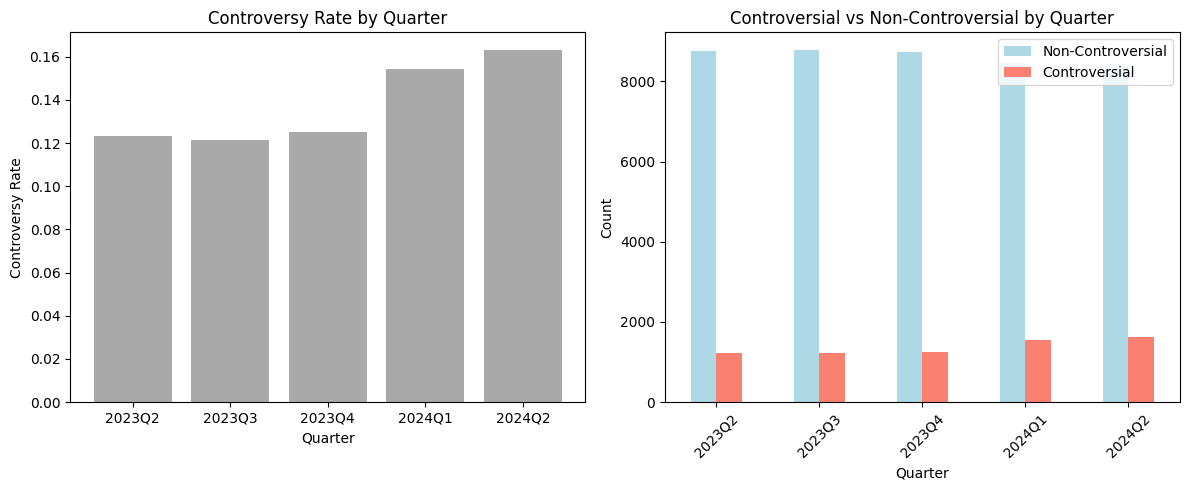

  quarter  count      mean
0  2023Q2   9988  0.123148
1  2023Q3   9998  0.121524
2  2023Q4   9994  0.125275
3  2024Q1   9992  0.154424
4  2024Q2   9992  0.163131

Overall controversy rate: 0.137


In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


quarter_controversy = (
    df_sample.groupby("quarter")["controversial"].agg(["count", "mean"]).reset_index()
)
axes[0].bar(
    range(len(quarter_controversy)), quarter_controversy["mean"], color="darkgray"
)
axes[0].set_title("Controversy Rate by Quarter")
axes[0].set_xlabel("Quarter")
axes[0].set_ylabel("Controversy Rate")
axes[0].set_xticks(range(len(quarter_controversy)))
axes[0].set_xticklabels(quarter_controversy["quarter"])


quarter_counts = (
    df_sample.groupby(["quarter", "controversial"]).size().unstack(fill_value=0)
)
quarter_counts.plot(kind="bar", ax=axes[1], color=["lightblue", "salmon"])
axes[1].set_title("Controversial vs Non-Controversial by Quarter")
axes[1].set_xlabel("Quarter")
axes[1].set_ylabel("Count")
axes[1].legend(["Non-Controversial", "Controversial"])
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

print(quarter_controversy)
print(f"\nOverall controversy rate: {df_sample['controversial'].mean():.3f}")


# Word Embeddings

We apply **BERT (Bidirectional Encoder Representations from Transformers)** embeddings because they can capture the contextual meaning of text. We choose BERT embeddings over TF-IDF vectors because they are better at understanding context and semantic relationships between words, rather than just treating text as a bag of words.

In [37]:
def get_bert_embeddings(texts, batch_size=32):
    """Generate BERT embeddings for text data"""
    print(f"Generating BERT embeddings for {len(texts)} texts...")

    # model
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    model = AutoModel.from_pretrained("bert-base-uncased")
    model.to(device)
    model.eval()

    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]

        # Tokenization and encoding
        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt",
        )
        encoded = {k: v.to(device) for k, v in encoded.items()}

        # Embeddings
        with torch.no_grad():
            outputs = model(**encoded)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()

        embeddings.extend(batch_embeddings)

        if i % 100 == 0:
            print(f"Processed {i + len(batch_texts)}/{len(texts)} texts")

    return np.array(embeddings)

# Modeling

## Topic Modeling Methods

### LDA

For LDA, we used a list of preprocessed, tokenized documents to create a bow corpus. We utilized the LdaMulticore implementation from Gensim for efficient parallel
processing.

In [38]:
def perform_lda_topic_modeling(tokens_list, label, num_topics=15):
    """Perform LDA topic modeling using Gensim"""
    print(f"\nPerforming LDA topic modeling for {label}")
    print(f"Number of documents: {len(tokens_list)}")

    if len(tokens_list) == 0:
        print(f"No data for {label}")
        return None, None, None

    processed_tokens = []
    for tokens in tokens_list:
        if isinstance(tokens, list) and len(tokens) > 0:
            processed_tokens.append(tokens)
        elif isinstance(tokens, str):
            processed_tokens.append(tokens.split())

    if len(processed_tokens) == 0:
        print(f"No valid documents after processing for {label}")
        return None, None, None

    # Create dictionary and corpus
    dictionary = Dictionary(processed_tokens)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    print(f"Dictionary size: {len(dictionary)} unique tokens")

    corpus = [dictionary.doc2bow(tokens) for tokens in processed_tokens]

    # Train LDA model
    lda_model = LdaMulticore(
        corpus,
        id2word=dictionary,
        num_topics=num_topics,
        workers=4,
        passes=2,
        random_state=RANDOM_SEED,
    )

    # print topics with words
    print(f"\nTopics for {label}:")
    for idx, topic in lda_model.print_topics(-1):
        print(f"Topic {idx}: {topic}")

    return lda_model, corpus, dictionary

The follwoing code splits the data into quarters and divides by labels. Then the topic modeling function is called to create the topics for each quarter and label combination. We decided to split by controvresial and quarter to see if there are differences in the topics over time for controversial conversations.

In [39]:
quarterly_data = {}
for quarter in quarters:
    quarterly_data[str(quarter)] = df_sample[df_sample["quarter"] == quarter]

lda_quarter_results = {}
for quarter in quarters:
    quarter_data = quarterly_data[str(quarter)]

    controversial_tokens = quarter_data[quarter_data["controversial"] == 1][
        "user_tokens"
    ].tolist()
    non_controversial_tokens = quarter_data[quarter_data["controversial"] == 0][
        "user_tokens"
    ].tolist()

    results = {}

    lda_model, corpus, dictionary = perform_lda_topic_modeling(
        controversial_tokens, f"{quarter} - Controversial"
    )
    results["controversial"] = {
        "lda": {"model": lda_model, "corpus": corpus, "dictionary": dictionary}
    }

    lda_model, corpus, dictionary = perform_lda_topic_modeling(
        non_controversial_tokens, f"{quarter} - Non-Controversial"
    )
    results["non_controversial"] = {
        "lda": {"model": lda_model, "corpus": corpus, "dictionary": dictionary}
    }

    lda_quarter_results[str(quarter)] = results



Performing LDA topic modeling for 2023Q2 - Controversial
Number of documents: 1230
Dictionary size: 7071 unique tokens

Topics for 2023Q2 - Controversial:
Topic 0: 0.006*"one" + 0.006*"like" + 0.005*"would" + 0.005*"also" + 0.004*"make" + 0.004*"world" + 0.004*"character" + 0.004*"write" + 0.003*"could" + 0.003*"time"
Topic 1: 0.005*"new" + 0.004*"one" + 0.004*"use" + 0.004*"file" + 0.004*"character" + 0.004*"write" + 0.004*"make" + 0.003*"args" + 0.003*"like" + 0.003*"text"
Topic 2: 0.007*"import" + 0.007*"image" + 0.007*"model" + 0.007*"x" + 0.005*"new" + 0.005*"const" + 0.005*"data" + 0.004*"like" + 0.004*"time" + 0.004*"text"
Topic 3: 0.005*"said" + 0.005*"people" + 0.005*"would" + 0.005*"one" + 0.004*"time" + 0.004*"make" + 0.004*"also" + 0.003*"like" + 0.003*"get" + 0.003*"u"
Topic 4: 0.004*"level" + 0.004*"number" + 0.004*"social" + 0.004*"time" + 0.004*"also" + 0.004*"one" + 0.003*"like" + 0.003*"word" + 0.003*"people" + 0.003*"life"
Topic 5: 0.005*"one" + 0.004*"time" + 0.003

### KMeans Clustering based on BERT Embeddings

We use Kmeans clustering on BERT embeddings to identify clusters of similar conversations.

In [ ]:
def perform_bert_topic_modeling(texts, label, num_topics=15):
    print(f"\nPerforming BERT topic modeling for {label}")
    print(f"Number of documents: {len(texts)}")

    embeddings = get_bert_embeddings(texts, batch_size=32)
    kmeans = KMeans(n_clusters=num_topics, random_state=RANDOM_SEED, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)

    topic_top_words = {}
    topic_doc_counts = {}

    # print the words
    print(f"\nBERT Topics for {label}:")
    for topic_id in range(num_topics):
        topic_texts = [
            texts[i] for i in range(len(texts)) if cluster_labels[i] == topic_id
        ]
        num_docs = len(topic_texts)
        topic_doc_counts[f"Topic {topic_id}"] = num_docs

        if topic_texts:
            all_words = [word for text in topic_texts for word in text.split()]
            top_words = Counter(all_words).most_common(10)

            topic_top_words[f"Topic {topic_id}"] = [word for word, count in top_words]

            print(f"Topic {topic_id} ({num_docs} documents):")
            print(f"  Top words: {', '.join([word for word, count in top_words])}")
        else:
            topic_top_words[f"Topic {topic_id}"] = []
            print(f"Topic {topic_id} ({num_docs} documents): No documents")

    return kmeans, embeddings, topic_top_words, topic_doc_counts


In [ ]:
bert_results = {}

for quarter in quarters:
    quarter_df = df_sample[df_sample["quarter"] == quarter]
    print(f"\n--- Quarter: {quarter} ---")

    controversial_docs = (
        quarter_df[quarter_df["controversial"] == 1]["user_text_processed"]
        .dropna()
        .tolist()
    )
    regular_docs = (
        quarter_df[quarter_df["controversial"] == 0]["user_text_processed"]
        .dropna()
        .tolist()
    )

    quarter_results = {}

    if controversial_docs:
        model, embeds, top_words, doc_counts = perform_bert_topic_modeling(
            controversial_docs, f"{quarter} controversial"
        )
        quarter_results["controversial"] = {
            "model": model,
            "embeddings": embeds,
            "top_words": top_words,
            "doc_counts": doc_counts,
        }
    else:
        print(f"No controversial documents found for {quarter}")
        quarter_results["controversial"] = None

    if regular_docs:
        model, embeds, top_words, doc_counts = perform_bert_topic_modeling(
            regular_docs, f"{quarter} regular"
        )
        quarter_results["regular"] = {
            "model": model,
            "embeddings": embeds,
            "top_words": top_words,
            "doc_counts": doc_counts,
        }
    else:
        print(f"No regular documents found for {quarter}")
        quarter_results["regular"] = None

    bert_results[str(quarter)] = quarter_results



--- Quarter: 2023Q2 ---

Performing BERT topic modeling for 2023Q2 controversial
Number of documents: 1230
Generating BERT embeddings for 1230 texts...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Processed 32/1230 texts
Processed 832/1230 texts

BERT Topics for 2023Q2 controversial:
Topic 0 (160 documents):
  Top words: word, write, would, time, use, one, make, like, following, woman
Topic 1 (35 documents):
  Top words: earring, manipulation, physiology, sexual, harassment, public, supernatural, artist, power, art
Topic 2 (64 documents):
  Top words: ayumi, amatsumagatsuchi, vanessa, would, girl, cupa, day, belly, sayori, look
Topic 3 (51 documents):
  Top words: error, code, const, type, int, return, list, date, none, void
Topic 4 (79 documents):
  Top words: write, please, make, round, game, list, day, give, best, first
Topic 5 (151 documents):
  Top words: write, like, make, story, would, day, one, x, also, new
Topic 6 (72 documents):
  Top words: write, make, please, question, answer, use, create, need, error, care
Topic 7 (179 documents):
  Top words: one, like, time, also, would, people, could, make, even, said
Topic 8 (62 documents):
  Top words: const, import, void, int


## Balancing

Balancing 50:50 to tackle the problem of class imbalance for model training.

In [ ]:
minority = df_sample[df_sample["controversial"] == 1]
majority = df_sample[df_sample["controversial"] == 0]

majority_downsampled = majority.sample(n=len(minority), random_state=42)

df_balanced = (
    pd.concat([minority, majority_downsampled])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

print(df_balanced["controversial"].value_counts())

controversial
0    6870
1    6870
Name: count, dtype: int64


## Vectorization

The models are trained on BERT embeddings.

In [ ]:
X_bert = get_bert_embeddings(df_balanced["user_text_processed"].tolist())
y = df_balanced["controversial"].values

print(f"BERT embeddings shape: {X_bert.shape}")
print(f"Labels shape: {y.shape}")

Generating BERT embeddings for 13740 texts...
Processed 32/13740 texts
Processed 832/13740 texts
Processed 1632/13740 texts
Processed 2432/13740 texts
Processed 3232/13740 texts
Processed 4032/13740 texts
Processed 4832/13740 texts
Processed 5632/13740 texts
Processed 6432/13740 texts
Processed 7232/13740 texts
Processed 8032/13740 texts
Processed 8832/13740 texts
Processed 9632/13740 texts
Processed 10432/13740 texts
Processed 11232/13740 texts
Processed 12032/13740 texts
Processed 12832/13740 texts
Processed 13632/13740 texts
BERT embeddings shape: (13740, 768)
Labels shape: (13740,)


## Split

The initial split is train/test with 80% for training and 20% for testing.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_bert, y, test_size=0.2, stratify=y, random_state=42
)

## Models

The goal is to create a model that can predict whether a conversation is controversial or not. 

This aligns with our Sub Research Question:

*Can we train a model to detect controversial ChatGPT conversations at scale?*


### Logistic Regression

The logistic regression model is our baseline model for the binary classification task,

In [ ]:
log_reg = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

### LSTM

The LSTM is our advanced neural network model for the binary classification task. It is designed to capture long-term dependencies in the text data, which is crucial for understanding the context of conversations.

In [ ]:
# Reshape
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


In [ ]:
# Model Architecture
lstm_model = Sequential(
    [
        LSTM(64, dropout=0.3, recurrent_dropout=0.3, input_shape=(1, X_bert.shape[1])),
        Dense(32, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid"),
    ]
)

lstm_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")

history = lstm_model.fit(
    X_train_lstm,
    y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1,
)

y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype(int).flatten()

Epoch 1/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6212 - loss: 0.6509 - val_accuracy: 0.7476 - val_loss: 0.5350
Epoch 2/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7258 - loss: 0.5669 - val_accuracy: 0.7522 - val_loss: 0.5206
Epoch 3/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7393 - loss: 0.5428 - val_accuracy: 0.7522 - val_loss: 0.5137
Epoch 4/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7448 - loss: 0.5339 - val_accuracy: 0.7544 - val_loss: 0.5102
Epoch 5/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7465 - loss: 0.5324 - val_accuracy: 0.7549 - val_loss: 0.5070
Epoch 6/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7553 - loss: 0.5230 - val_accuracy: 0.7572 - val_loss: 0.5042
Epoch 7/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7512 - loss: 0.5227 - val_accuracy: 0.7599 - val_loss: 0.4993
Epoch 8/30
275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7547 - loss: 0.5220 - val_accuracy: 0

# Evaluation

## Topic Modeling

### LDA

For the model evaluation, we first assign each conversation to a topic based on the highest probability of the topic distribution. After that we calculate the average controversy score for each topic based on the assigned conversations.

In [ ]:
quarterly_top_topics = {}

for quarter in quarters:
    quarter_str = str(quarter)

    lda_model = lda_quarter_results[quarter_str]["controversial"]["lda"]["model"]
    dictionary = lda_quarter_results[quarter_str]["controversial"]["lda"]["dictionary"]

    quarter_data = df_sample[
        (df_sample["quarter"] == quarter) & (df_sample["controversial"] == 1)
    ].copy()

    topic_scores = {}

    for idx, row in quarter_data.iterrows():
        tokens = row["user_tokens"]
        if isinstance(tokens, list) and len(tokens) > 0:
            bow = dictionary.doc2bow(tokens)
            topic_dist = lda_model.get_document_topics(bow)

            if topic_dist:
                dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
                if dominant_topic not in topic_scores:
                    topic_scores[dominant_topic] = []
                topic_scores[dominant_topic].append(row["controversy_score"])

    if topic_scores:
        best_topic = max(topic_scores.keys(), key=lambda t: np.mean(topic_scores[t]))
        avg_score = np.mean(topic_scores[best_topic])

        topic_words = lda_model.show_topic(best_topic, topn=10)
        keywords = ", ".join([word for word, prob in topic_words])

        quarterly_top_topics[quarter_str] = {
            "quarter": quarter,
            "topic": best_topic,
            "avg_controversy_score": avg_score,
            "keywords": keywords,
        }

top_topics_df = pd.DataFrame(list(quarterly_top_topics.values()))
print(top_topics_df)

  quarter  topic  avg_controversy_score  \
0  2023Q2     11               0.428618   
1  2023Q3     14               0.420520   
2  2023Q4     13               0.439120   
3  2024Q1     13               0.463961   
4  2024Q2      9               0.463983   

                                            keywords  
0  ayumi, amatsumagatsuchi, vanessa, would, maste...  
1  power, ability, also, manipulation, often, god...  
2  de, la, que, mi, julien, cheese, like, one, e,...  
3  slade, dick, nightshade, way, world, people, s...  
4  state, class, power, capitalist, form, relatio...  


Visualization of the LDA topics using pyLDAvis for Quarter2 in 2023.

In [ ]:
quarter_key = "2023Q2"

print(f"=== LDA Results for {quarter_key} - Controversial Topics ===")

lda_model = lda_quarter_results[quarter_key]["controversial"]["lda"]["model"]
dictionary = lda_quarter_results[quarter_key]["controversial"]["lda"]["dictionary"]
corpus = lda_quarter_results[quarter_key]["controversial"]["lda"]["corpus"]


pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

=== LDA Results for 2023Q2 - Controversial Topics ===


Visualization of the LDA topics using pyLDAvis for Quarter2 in 2024.

In [ ]:
quarter_key = "2024Q2"

print(f"=== LDA Results for {quarter_key} - Controversial Topics ===")

lda_model = lda_quarter_results[quarter_key]["controversial"]["lda"]["model"]
dictionary = lda_quarter_results[quarter_key]["controversial"]["lda"]["dictionary"]
corpus = lda_quarter_results[quarter_key]["controversial"]["lda"]["corpus"]


pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

=== LDA Results for 2024Q2 - Controversial Topics ===


### KMeans


The same evaluation technique is applied to KMeans clustering.

In [ ]:
quarterly_top_topics_bert = {}

for quarter in quarters:
    quarter_str = str(quarter)

    if (
        quarter_str in bert_results
        and bert_results[quarter_str]["controversial"] is not None
    ):
        quarter_data = df_sample[
            (df_sample["quarter"] == quarter) & (df_sample["controversial"] == 1)
        ].copy()

        kmeans_model = bert_results[quarter_str]["controversial"]["model"]
        embeddings = bert_results[quarter_str]["controversial"]["embeddings"]
        top_words = bert_results[quarter_str]["controversial"]["top_words"]

        cluster_labels = kmeans_model.labels_

        topic_scores = {}
        for i, cluster_id in enumerate(cluster_labels):
            if cluster_id not in topic_scores:
                topic_scores[cluster_id] = []

            controversy_score = quarter_data.iloc[i]["controversy_score"]
            topic_scores[cluster_id].append(controversy_score)

        if topic_scores:
            best_topic = max(
                topic_scores.keys(), key=lambda t: np.mean(topic_scores[t])
            )
            avg_score = np.mean(topic_scores[best_topic])

            keywords = ", ".join(top_words[f"Topic {best_topic}"])

            quarterly_top_topics_bert[quarter_str] = {
                "quarter": quarter,
                "topic": best_topic,
                "avg_controversy_score": avg_score,
                "keywords": keywords,
            }


top_topics_bert_df = pd.DataFrame(list(quarterly_top_topics_bert.values()))
print("BERT Topic Modeling Results:")
print(top_topics_bert_df)


BERT Topic Modeling Results:
  quarter  topic  avg_controversy_score  \
0  2023Q2      2               0.430953   
1  2023Q3      4               0.423048   
2  2023Q4      8               0.438292   
3  2024Q1      3               0.489474   
4  2024Q2     10               0.440468   

                                            keywords  
0  ayumi, amatsumagatsuchi, vanessa, would, girl,...  
1  power, character, often, ability, eddy, hair, ...  
2  rhaenyra, nyra, character, one, daemion, like,...  
3  slade, dick, nightshade, like, way, world, tec...  
4  state, power, also, class, capitalist, empire,...  


We display one example conversation for each quarter from the topic with the highest average controversy score.

In [ ]:
def display_topic_conversation(quarter, topic_id, conversation_index=0):
    if quarter not in bert_results or bert_results[quarter]["controversial"] is None:
        print(f"No BERT results found for quarter {quarter}")
        return

    cluster_labels = bert_results[quarter]["controversial"]["model"].labels_

    controversial = df_sample[
        (df_sample["quarter"] == quarter) & (df_sample["controversial"] == 1)
    ].reset_index(drop=True)

    topic_indices = [i for i, label in enumerate(cluster_labels) if label == topic_id]

    conversation = controversial.iloc[topic_indices[conversation_index]]
    print(f"Quarter: {quarter}, Topic: {topic_id}, Conversation {conversation_index}:")
    print(conversation["conversation"])


In [ ]:
display_topic_conversation("2023Q2", 2, 15)

Quarter: 2023Q2, Topic: 2, Conversation 15:
[{'content': 'I want you to write me an interesting story about a villain. This villain fights against a main hero team. But he is actually the aged up child of a scientist lady that is affiliated with the hero team. He was abducted when he was three years old by an evil drone running an evil galactic empire and genetically turned into an adult. He was also given a new identity and name. This villain gets to meet his mother for the first time. He is happy but she is horrified to find out that her child is working for the forces of evil and has done such horrible things. After a long talk they finally make up. But at one point he starts needing to pee very badly. Even though he is redeemed he still wants to keep up his intimidating fearsome persona and doesn’t want to embarrass himself in front of her. The villain is very androgynous and is more on the gender neutral side but for the sake of this story just refer to them as he/him. Make it kin

In [ ]:
display_topic_conversation("2023Q3", 4, 15)

Quarter: 2023Q3, Topic: 4, Conversation 15:
[{'content': 'Give a Really Shortest Description Backstory about Power Rangers/SCP Foundation Merged Together x Skullgirls Crossover Timeline, SCP-XXXX “The Invincible Ranger”/Tommy Oliver (Filia, Cerebella, Peacock, Parasoul, Ms. Fortune, Painwheel, Ms. Fortune, Valentine, Squigly, Fukua, Eliza, Robo-Fortune, Annie, Umbrella, Black Dahlia, and Marie’s Boyfriend) meeting these characters, Filia, Cerebella, Peacock, Parasoul, Ms. Fortune, Painwheel, Ms. Fortune, Valentine, Squigly, Fukua, Eliza, Robo-Fortune, Annie, Umbrella, Black Dahlia, Marie, and the rest of the characters in Skullgirls, and SCP-XXXX “The Invincible Ranger”, Object Class: Safe, Description: SCP-XXXX is an individual identified as Tommy Oliver, formerly known as the Green Ranger, White Ranger, Red Zeo Ranger, Turbo Red Ranger, and Dino Thunder Black Ranger in various iterations of the Power Rangers media franchise. SCP-XXXX displays a variety of anomalous abilities and attr

In [ ]:
display_topic_conversation("2023Q4", 8, 15)

Quarter: 2023Q4, Topic: 8, Conversation 15:
[{'content': 'Ash was an anthropomorphic grey furred cheetah, the spaceship he was flying got trapped in an unforeseeable quantum gravity event. The cheetah decided to try to escape it through the mean of a hyperspace jump, the position of an inhabited planet of his guild was entered in the computer but due of the event the engines of his ship got in an overdrive state. The jump occurred but the combination of these facts made his ship jump in an indeterminate place of the space-time. The engines were damaged and not so much energy was remaining. And the cheetah realized with horror the planet where is ship was now orbiting was not the one he oped for. In fact neither him nor his computer could recognize it it was an unknown world. The hope were dim. He tried to calculate his position but his computer could not figure it out and he was not receiving any replies to the distress signals he launched.\nHis computer confirmed the planet sustaining

In [ ]:
display_topic_conversation("2024Q1", 3, 15)

Quarter: 2024Q1, Topic: 3, Conversation 15:
[{'content': 'How\'s this for an anti-hero version of Dick Grayson(called Nightshade or \'Grayson\' for his real name) in this alternate DC universe?.....basically...its an inverted version of Dick Grayson.....both have similar traits....but notable differences...\n\nNightshade has similar origins to main universe Dick...but things diverged...to where he never was taken by Bruce..because Bruce wasn\'t there at the time...rather.....it was Joseph \'Slade\' Wilson instead....who was there at Haly\'s Circus because he received intel that the Court of Owls....was involved in the Circus for some reason......then was there in that pivotal moment...he was there in the crowd as the tragedy occurred....as Slade saw potential in the young Dick Grayson then and there.....mixed with his own ruthlessness.....as Slade was \'inspired\' by the duo of Batman and Robin....if Batman has his own Robin...hey....\n\nThe inspiration is pretty much Dick Grayson with

In [ ]:
display_topic_conversation("2024Q2", 10, 15)

Quarter: 2024Q2, Topic: 10, Conversation 15:
[{'content': 'Can I tell you about an alternate history scenario I made?', 'country': 'Romania', 'hashed_ip': '3618f332f87a28193510ac02748f7ebe6a7ece470493b15bacedf5cdaf57c496', 'header': {'accept-language': 'en-US,en;q=0.9', 'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36 OPR/107.0.0.0'}, 'language': 'English', 'redacted': False, 'role': 'user', 'state': 'Galați County', 'timestamp': None, 'toxic': False, 'turn_identifier': 2649223}
 {'content': "Yes, please feel free to share your alternate history scenario. I'm interested to hear what you've created and can offer insights or feedback if you'd like.", 'country': None, 'hashed_ip': None, 'header': None, 'language': 'English', 'redacted': False, 'role': 'assistant', 'state': None, 'timestamp': datetime.datetime(2024, 4, 7, 9, 21, 43, tzinfo=<UTC>), 'toxic': False, 'turn_identifier': 2649223}
 {'content': 'In this 

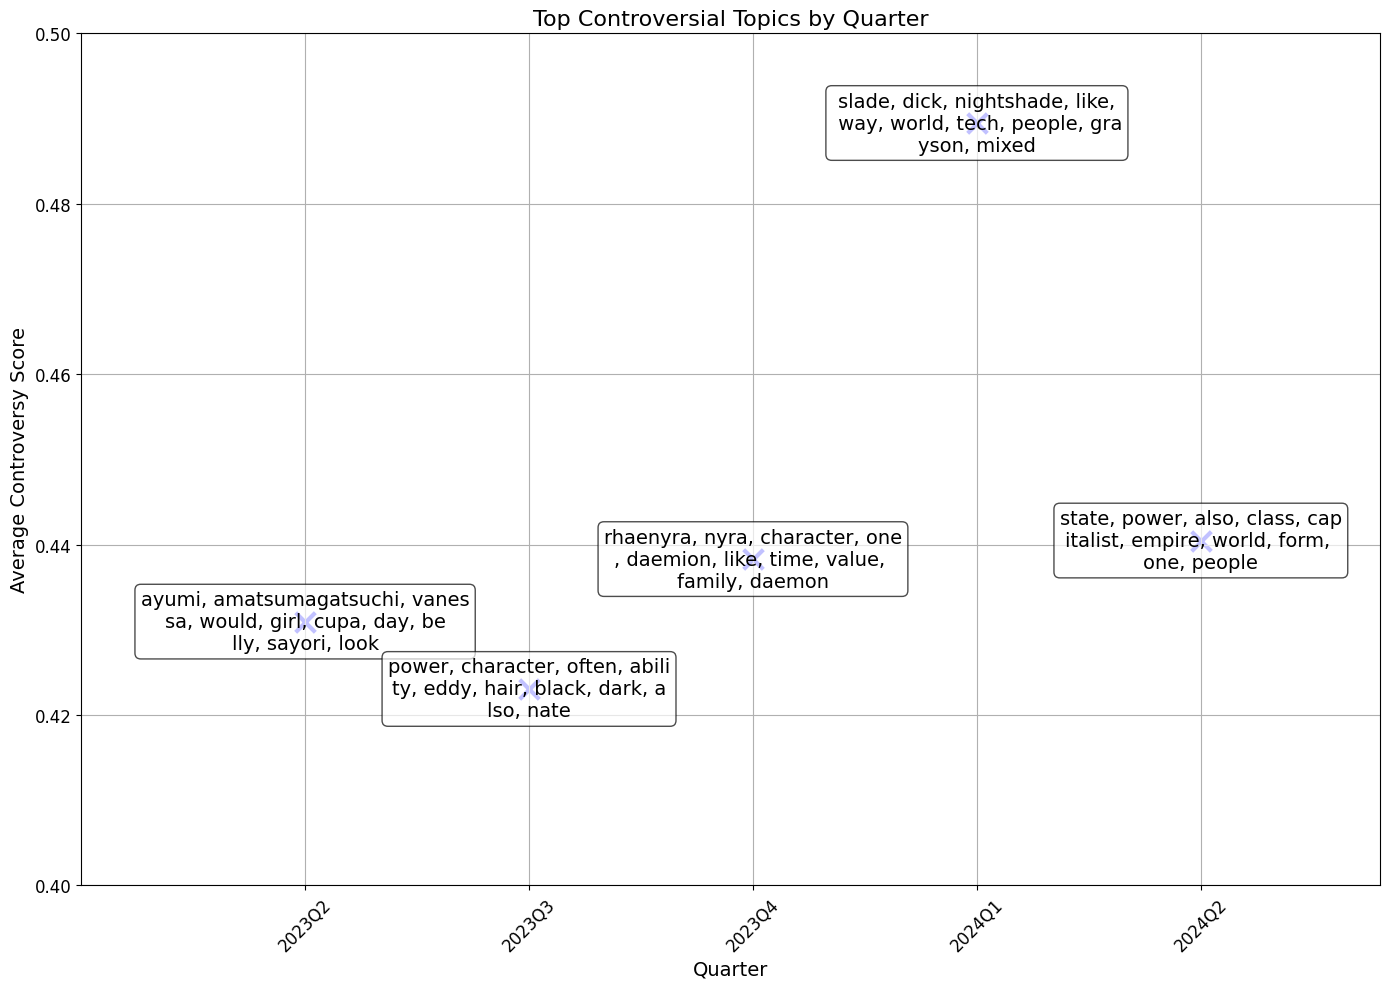

In [ ]:
def plot_top_topics(topics_df):
    plt.figure(figsize=(14, 10))

    plt.scatter(
        topics_df["quarter"],
        topics_df["avg_controversy_score"],
        s=200,
        alpha=0.8,
        c="blue",
        marker="x",
        linewidth=3,
    )

    for i, row in topics_df.iterrows():
        keywords = row["keywords"]
        wrapped_text = "\n".join(
            [keywords[i : i + 30] for i in range(0, len(keywords), 30)]
        )

        plt.text(
            row["quarter"],
            row["avg_controversy_score"],
            wrapped_text,
            fontsize=14,
            ha="center",
            va="center",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7),
        )

    plt.title("Top Controversial Topics by Quarter", fontsize=16)
    plt.xlabel("Quarter", fontsize=14)
    plt.ylabel("Average Controversy Score", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0.4, 0.5)
    plt.xlim(-1, len(topics_df) - 0.2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_top_topics(top_topics_bert_df)

## Models


We use the classication report and confusion matrix to evaluate the performance of the models.

### Logistic Regression

              precision    recall  f1-score   support

           0       0.78      0.73      0.76      1374
           1       0.75      0.79      0.77      1374

    accuracy                           0.76      2748
   macro avg       0.76      0.76      0.76      2748
weighted avg       0.76      0.76      0.76      2748



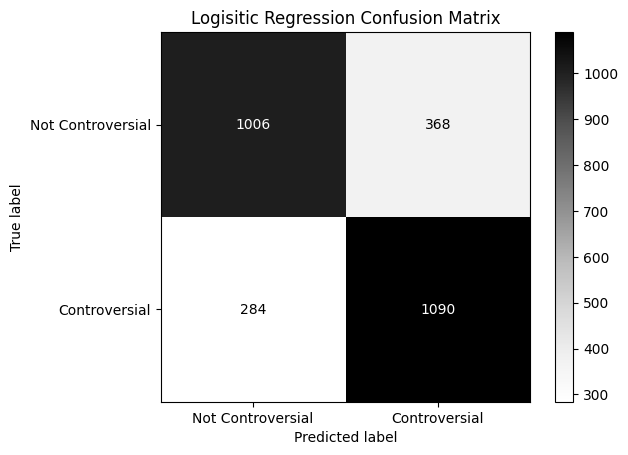

Training Accuracy: 0.7900
Test Accuracy: 0.7627


In [ ]:
print(classification_report(y_test, y_pred, digits=2))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Not Controversial", "Controversial"]
)
disp.plot(cmap="Greys")
plt.title("Logisitic Regression Confusion Matrix")
plt.show()

train_accuracy = log_reg.score(X_train, y_train)
test_accuracy = log_reg.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
test_indices = X_test_indices if "X_test_indices" in locals() else range(len(y_test))


df_eval_lr = pd.DataFrame({"True_label": y_test, "Predicted_label": y_pred})


fp = df_eval_lr[(df_eval_lr["True_label"] == 0) & (df_eval_lr["Predicted_label"] == 1)]
fn = df_eval_lr[(df_eval_lr["True_label"] == 1) & (df_eval_lr["Predicted_label"] == 0)]


if len(fp) >= 3:
    fp_sample = fp.sample(n=3, random_state=42)
    print("\n3 Random False Positive Examples:")
    for i, (idx, row) in enumerate(fp_sample.iterrows()):
        if idx < len(df_balanced):
            conversation = df_balanced.iloc[idx]["user_text_processed"]
            print(
                f"{i + 1}. True: {row['True_label']}, Predicted: {row['Predicted_label']}"
            )
            print(f"Conversation: {conversation}\n")

if len(fn) >= 3:
    fn_sample = fn.sample(n=3, random_state=4)
    print("\n3 Random False Negative Examples:")
    for i, (idx, row) in enumerate(fn_sample.iterrows()):
        if idx < len(df_balanced):
            conversation = df_balanced.iloc[idx]["user_text_processed"]
            print(
                f"{i + 1}. True: {row['True_label']}, Predicted: {row['Predicted_label']}"
            )
            print(f"Conversation: {conversation}\n")



3 Random False Positive Examples:
1. True: 0, Predicted: 1
   Conversation: according topic research study impact two different school teaching learning focusing grade provide title research proposal elaborate change topic student teacher affected teaching learning focusing two different primary school focusing grade research proposal according research proposal far examining influence school grade teaching learning comparative analysis topic analysing interaction student teacher experience grade education within primary school research proposal aim investigate complex relationship student teacher learning environment grade education within primary school focusing two distinct school study seek assess multifaceted impact resource limitation teaching learning experience grade investigating perception experience student teacher research aim provide valuable insight challenge faced potential strategy improving education delivery background effective teaching within primary school huge co

### LSTM

For the LSTM model we further plot the accurcy and loss over the epochs to visualize the training process.

              precision    recall  f1-score   support

           0       0.83      0.67      0.74      1374
           1       0.72      0.86      0.78      1374

    accuracy                           0.76      2748
   macro avg       0.77      0.76      0.76      2748
weighted avg       0.77      0.76      0.76      2748



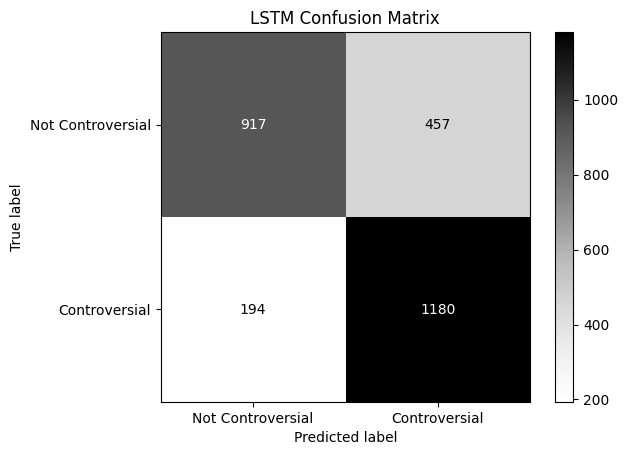

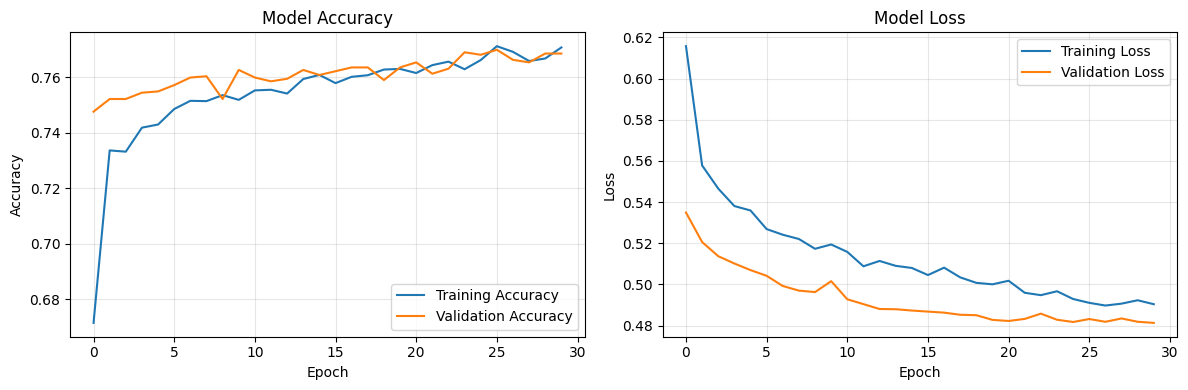

In [ ]:
print(classification_report(y_test, y_pred_lstm, digits=2))

cm = confusion_matrix(y_test, y_pred_lstm)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Not Controversial", "Controversial"]
)
disp.plot(cmap="Greys")
plt.title("LSTM Confusion Matrix")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
axes[0].plot(history.history["accuracy"], label="Training Accuracy")
axes[0].plot(history.history["val_accuracy"], label="Validation Accuracy")
axes[0].set_title("Model Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history["loss"], label="Training Loss")
axes[1].plot(history.history["val_loss"], label="Validation Loss")
axes[1].set_title("Model Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
